# Image Segmentation on Oxford-IIIT Pets dataset

<p>Source: https://www.kaggle.com/datasets/devdgohil/the-oxfordiiit-pet-dataset

In [2]:
import os

input_dir = "oxford-pets/images/"
target_dir = "oxford-pets/annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

print("Number of samples:", len(input_img_paths))


Number of samples: 7390


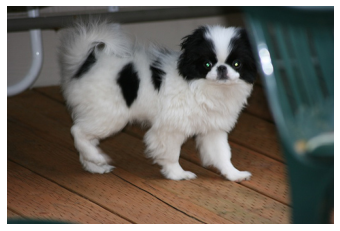

In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[4]))

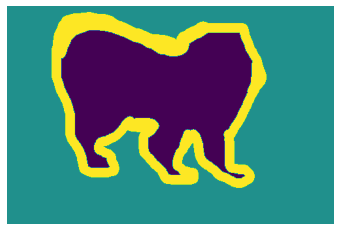

In [13]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[4], color_mode="grayscale"))
display_target(img)

In [8]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

num_classes=3

model = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=img_size + (3,)),
    layers.Conv2D(64, 3, strides=2, activation="relu", padding="same"),
    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.Conv2D(128, 3, strides=2, activation="relu", padding="same"),
    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.Conv2D(256, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2D(256, 3, activation="relu", padding="same"),

    layers.Conv2DTranspose(256, 3, activation="relu", padding="same"),
    layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2),
    layers.Conv2DTranspose(128, 3, activation="relu", padding="same"),
    layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2),
    layers.Conv2DTranspose(64, 3, activation="relu", padding="same"),
    layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2),

    layers.Conv2D(num_classes, 3, activation="softmax", padding="same")    
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 256)       5

In [7]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",save_best_only=True)]

history = model.fit(train_input_imgs, train_targets,
                    epochs=10,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/10
100/100 [==============================] - 1005s 10s/step - loss: 1.6815 - accuracy: 0.5815 - val_loss: 0.8628 - val_accuracy: 0.6005
Epoch 2/10
100/100 [==============================] - 1002s 10s/step - loss: 0.7987 - accuracy: 0.6749 - val_loss: 0.7559 - val_accuracy: 0.7056
Epoch 3/10
100/100 [==============================] - 989s 10s/step - loss: 0.7762 - accuracy: 0.6875 - val_loss: 0.7649 - val_accuracy: 0.6936
Epoch 4/10
100/100 [==============================] - 992s 10s/step - loss: 0.7599 - accuracy: 0.6965 - val_loss: 0.6494 - val_accuracy: 0.7354
Epoch 5/10
100/100 [==============================] - 993s 10s/step - loss: 0.6910 - accuracy: 0.7186 - val_loss: 0.7786 - val_accuracy: 0.6779
Epoch 6/10
100/100 [==============================] - 993s 10s/step - loss: 0.6576 - accuracy: 0.7333 - val_loss: 0.5657 - val_accuracy: 0.7721
Epoch 7/10
100/100 [==============================] - 1000s 10s/step - loss: 0.6071 - accuracy: 0.7569 - val_loss: 0.5567 - val_accura

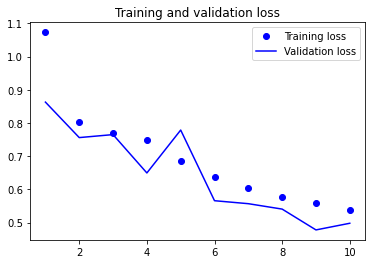

In [8]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

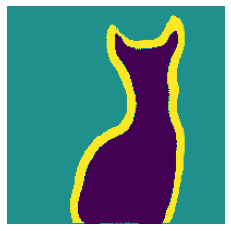

In [17]:
from keras.preprocessing.image import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 1
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)